In [ ]:
# download the data
! wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1sL8ZzGo56zE05IEeOW3qFTUSs8EOzb0A' -O "kaggle.json"
! mkdir ~/.kaggle
! cp ./kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en

--2022-05-17 20:13:30--  https://docs.google.com/uc?export=download&id=1sL8ZzGo56zE05IEeOW3qFTUSs8EOzb0A
Resolving docs.google.com (docs.google.com)... 209.85.145.139, 209.85.145.100, 209.85.145.102, ...
Connecting to docs.google.com (docs.google.com)|209.85.145.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-0s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rmavmaimft2nf2t0h9qrc8uel98leab9/1652818350000/14000593078586114621/*/1sL8ZzGo56zE05IEeOW3qFTUSs8EOzb0A?e=download [following]
--2022-05-17 20:13:31--  https://doc-0c-0s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rmavmaimft2nf2t0h9qrc8uel98leab9/1652818350000/14000593078586114621/*/1sL8ZzGo56zE05IEeOW3qFTUSs8EOzb0A?e=download
Resolving doc-0c-0s-docs.googleusercontent.com (doc-0c-0s-docs.googleusercontent.com)... 142.250.1.132, 2607:f8b0:4001:c24::84
Connecting to doc-0c-0s-docs.googleusercontent.com (doc-0c-0s-docs.googl

In [ ]:
! unzip -q speech-emotion-recognition-en.zip -d /content/data # extract the data
! rm speech-emotion-recognition-en.zip # remove .zip file to save some space

In [ ]:
import numpy as np
import scipy.io.wavfile
import os
import librosa as lb
import librosa.display
import tensorflow as tf
from tensorflow.keras.layers import Dense , Dropout , Activation , Flatten , Conv2D , MaxPooling2D , ZeroPadding2D , Conv1D , MaxPool1D,MaxPooling1D
from matplotlib import pyplot as plt
from IPython.display import Audio
from keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K

In [ ]:
dataFolder = 'data/Crema'
labels=np.zeros(7442)
data=[]
i=0
for sample in os.listdir(dataFolder):
    
    samp, sr = lb.load(dataFolder+"/"+sample, offset=0.6, duration=3 , sr=None)
    samp=np.pad(samp, pad_width=(0,48000-samp.shape[0]))
    data.append(samp)
    token = sample.partition(".wav")[0].split("_")
    if token[2] == 'SAD':
        labels[i]=0;
    elif token[2] == 'ANG':
        labels[i]=1;
    elif token[2] == 'DIS':
        labels[i]=2;
    elif token[2] == 'FEA':
        labels[i]=3;
    elif token[2] == 'HAP':
        labels[i]=4;
    elif token[2] == 'NEU':
        labels[i]=5;
    else:
        labels[i]=6;

    i=i+1


In [ ]:
import math
def get_white_noise(signal,SNR) :
    #RMS value of signal
    RMS_s=math.sqrt(np.mean(signal**2))
    #RMS values of noise
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    #Additive white gausian noise. Thereore mean=0
    #Because sample length is large (typically > 40000)
    #we can use the population formula for standard daviation.
    #because mean=0 STD=RMS
    STD_n=RMS_n
    noise=np.random.normal(0, STD_n, signal.shape[0])
    return noise

In [ ]:
from sklearn.model_selection import train_test_split
#spliting dataset

x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.3 ,shuffle = False, stratify = None)

x_train_new, x_val, y_train_new, y_val = train_test_split(x_train, y_train, test_size=0.05 ,shuffle = False, stratify = None)

x_train=np.array(x_train_new)
x_test=np.array(x_test)
x_val=np.array(x_val) 

y_train=np.array(y_train_new)
y_test=np.array(y_test)
y_val=np.array(y_val)

#augmenting training dataset
moded_xtrain = []
moded_ytrain=[]
for i in range(x_train.shape[0]):

  withnoise = get_white_noise(x_train[i] ,7)
  withpitch=librosa.effects.pitch_shift(x_train[i], sr , 0.7)
  #stretched =  librosa.effects.time_stretch(x_train[i], 0.8)
  moded_xtrain.append(x_train[i])
  moded_xtrain.append(withnoise)
  moded_xtrain.append(withpitch)
  
  moded_ytrain.append(y_train[i])
  moded_ytrain.append(y_train[i])
  moded_ytrain.append(y_train[i])

In [ ]:
sh=x_train.shape[1]
print(x_train[0].shape)
print(sh)

(48000,)
48000


In [ ]:
def zcr(data):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=2048, hop_length=512)
    return np.squeeze(zcr)
def mfcc(data, sr=16000, flatten: bool = True): #get Mel-frequency cepstrum coefficients 
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)
def rmse(data): #energy for each frame
    rmse = librosa.feature.rms(y=data, frame_length=2048, hop_length=512)
    return np.squeeze(rmse)
def energy(data):
    ene = np.array([np.sum(np.power(np.abs(data[hop:hop+2048]), 2)) for hop in range(0, data.shape[0], 512)])
    return ene / 2048

In [ ]:
x=[]
for i in moded_xtrain :
  sample = np.array([])
  sample = np.hstack( (sample ,zcr(i),rmse(i),mfcc(i),energy(i)))
  x.append(sample)

In [ ]:
x_t=[]
for i in x_test :
  sample = np.array([])
  sample = np.hstack(  (sample ,zcr(i),rmse(i),mfcc(i),energy(i)))
  x_t.append(sample)

In [ ]:
val=[]
for i in x_val :
  sample = np.array([])
  sample = np.hstack(  (sample ,zcr(i),rmse(i),mfcc(i),energy(i)))
  val.append(sample)

In [ ]:
  moded_xtrain= np.array(x)
  moded_xtest=np.array(x_t)
  moded_xval=np.array(val)

In [ ]:
moded_xtest = np.expand_dims(moded_xtest, axis=2)
moded_xtrain = np.expand_dims(moded_xtrain, axis=2)
moded_xval = np.expand_dims(moded_xval, axis=2)

In [ ]:
from keras import models
from keras import layers
from keras import models
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import itertools
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
tf.keras.backend.clear_session()
model = Sequential()
model.add(Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(moded_xtrain.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(6, activation="softmax"))

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2162, 512)         3072      
                                                                 
 batch_normalization (BatchN  (None, 2162, 512)        2048      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1081, 512)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1081, 512)         1311232   
                                                                 
 batch_normalization_1 (Batc  (None, 1081, 512)        2048      
 hNormalization)                                                 
                                                        

In [ ]:
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
reduction = ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [ ]:
from tensorflow.keras.utils import to_categorical
ytrain=to_categorical(moded_ytrain)
yval=to_categorical(y_val)
ytest=to_categorical(y_test)

print(moded_xtrain.shape)
print(moded_xtest.shape)
print(moded_xval.shape)

print(ytrain.shape)
print(ytest.shape)
print(yval.shape)

record=model.fit(moded_xtrain , ytrain , epochs=30, validation_data=(moded_xval, yval), callbacks=[reduction])

(14844, 2162, 1)
(2233, 2162, 1)
(261, 2162, 1)
(14844, 6)
(2233, 6)
(261, 6)
Epoch 1/30
464/464 [==============================] - 184s 366ms/step - loss: 1.6541 - accuracy: 0.3580 - val_loss: 2.4242 - val_accuracy: 0.2874 - lr: 0.0010
Epoch 2/30
464/464 [==============================] - 168s 362ms/step - loss: 1.4750 - accuracy: 0.4082 - val_loss: 1.7968 - val_accuracy: 0.3525 - lr: 0.0010
Epoch 3/30
464/464 [==============================] - 168s 362ms/step - loss: 1.4206 - accuracy: 0.4306 - val_loss: 2.2688 - val_accuracy: 0.3065 - lr: 0.0010
Epoch 4/30
464/464 [==============================] - 168s 361ms/step - loss: 1.3897 - accuracy: 0.4405 - val_loss: 1.5212 - val_accuracy: 0.3946 - lr: 0.0010
Epoch 5/30
464/464 [==============================] - 168s 362ms/step - loss: 1.3594 - accuracy: 0.4532 - val_loss: 1.6745 - val_accuracy: 0.3908 - lr: 0.0010
Epoch 6/30
464/464 [==============================] - 168s 362ms/step - loss: 1.3233 - accuracy: 0.4731 - val_loss: 1.6223 - va

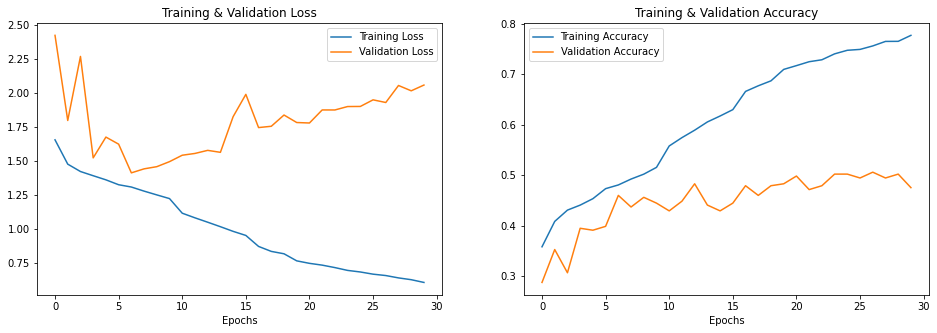

              precision    recall  f1-score   support

         0.0       0.46      0.50      0.48       349
         1.0       0.61      0.68      0.64       373
         2.0       0.46      0.42      0.44       398
         3.0       0.52      0.37      0.43       404
         4.0       0.47      0.51      0.49       369
         5.0       0.52      0.59      0.55       340

    accuracy                           0.51      2233
   macro avg       0.51      0.51      0.51      2233
weighted avg       0.51      0.51      0.50      2233



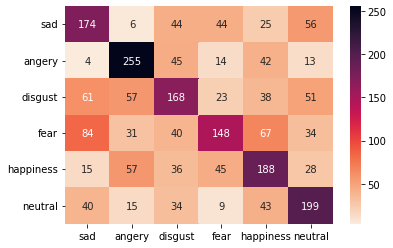

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
#graphs , confusion matrix ,and f meausre
train_ac = record.history['accuracy']
train_loss = record.history['loss']
test_ac = record.history['val_accuracy']
test_loss = record.history['val_loss']

fig , ax = plt.subplots(1,2)
fig.set_size_inches(16,5)
ax[0].plot(train_loss, label = 'Training Loss')
ax[0].plot(test_loss , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_ac, label = 'Training Accuracy')
ax[1].plot(test_ac , label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


#SAD,ANG,DIS,FEA,HAP,and NEU and save them as corresponding labels 0,1,2,3,4,5,and 6 respectivly
y_pred = model.predict(moded_xtest)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_bool))


matrix = confusion_matrix(y_test, y_pred.argmax(axis=1))
ax = sns.heatmap(matrix, annot=True, fmt="d", cmap = 'rocket_r', xticklabels = ['sad','angery','disgust','fear', 'happiness', 'neutral'], yticklabels = ['sad','angery','disgust','fear', 'happiness', 'neutral'])
